In [78]:
# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Geographical analysis
import geopandas as gpd #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5
import pandana
# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')

Libraries imported.


# Data  Wrangelling - Dropping stage

In [79]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '2020.ipynb',
 'accessibility-ams.png',
 'ams_Venues.csv',
 'Bruder__Lukas_11124202_BSc_ECB.pdf',
 'calendarr.csv',
 'foursquare_amenities.csv',
 'inde_variables.npy',
 'listings (1).csv',
 'listingss.csv',
 'listings_cleaned.csv',
 'listings_model.csv',
 'logs',
 'logs.log',
 'models.png',
 'model_weights.h5',
 'mynetwork.h5',
 'neighbourhoods.geojson',
 'pedagogical.ipynb',
 'predictive_models.ipynb',
 'target.npy',
 'tdf.csv',
 'time_series4.jpg',
 'time_series5.pdf',
 'time_seriess.jpg',
 'Untitled.ipynb']

In [80]:
raw_df=pd.read_csv('listingss.csv')

In [81]:
print(f"The dataset contains {len(raw_df)} Airbnb listings")#or ''+str(raw_df)+''
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 20001 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20200105171934,2020-01-06,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,NaN,NaN,Please: - Leave your shoes in the entrance - ...,NaN,NaN,https://a0.muscache.com/im/pictures/10272854/8...,NaN,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Indische Buurt,Oostelijk Havengebied - Indische Buurt,NaN,Amsterdam,North Holland,NaN,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.36575,4.94142,f,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",NaN,$59.00,NaN,"$1,500.00",$200.00,$60.00,1,$20.00,3,15,3,3,1125,1125,3.0,1125.0,3 weeks ago,t,17,17,17,17,2020-01-06,277,27,2009-03-30,2019-11-21,98.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,"{Amsterdam,"" NL Zip Codes 2"","" Amsterdam"","" NL""}",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.11
1,20168,https://www.airbnb.com/rooms/20168,20200105171934,2020-01-06,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,For those who like all facets of city life. In...,17th century Dutch townhouse in the heart of t...,none,Located just in between famous central canals....,Check-in time from 2pm till 10pm (But it doesn...,No need to use any transport! All is within a ...,NaN,"No curfew, free entrance 27/7 with your own ke...",This studio/room takes entire floor and has it...,NaN,NaN,https://a0.muscache.com/im/pictures/69979664/3...,NaN,59484,https://www.airbnb.com/users/show/59484,Alexander,2009-12-02,"Amsterdam, Noord-Holland, The Netherlands",Secondary phone nr. + (Phone number hidden by ...,within an hour,100%,NaN,f,https://a0

In [82]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*raw_df.shape))

# ... and duplicates
print("It contains {} duplicates.".format(raw_df.duplicated().sum()))

The dataset has 20001 rows and 106 columns.
It contains 0 duplicates.


In [83]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 16.2+ MB


In [84]:
df=raw_df.copy()

In [85]:
categoricals = [var for var in df.columns if df[var].dtype=='object']
numerics = [var for var in df.columns if (df[var].dtype=='int64')|(df[var].dtype=='float64')]
dates=[var for var in df.columns if df[var].dtype=='datetime64[ns]']

In [86]:
#Are there any variables with object datatype which is numeric intrinsically ? No
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [87]:
(df[numerics].isnull().sum()/len(df)*100)\
            .to_frame()\
            .rename(columns={0:'percentage of missing values of numerics variables'})\
            .T
            

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
percentage of missing values of numerics variables,0.0,0.0,100.0,100.0,100.0,0.0,100.0,0.259987,0.259987,100.0,0.0,0.0,0.0,0.029999,0.089996,0.179991,98.220089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.279386,12.334383,12.329384,12.374381,12.334383,12.364382,12.364382,0.0,0.0,0.0,0.0,11.169442


In [88]:
(df[categoricals].isnull().sum()/len(df)*100)\
            .to_frame()\
            .rename(columns={0:'percentage of missing values of numerics variables'})\
            .T

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
percentage of missing values of numerics variables,0.0,0.0,0.169992,3.109845,26.623669,1.229939,0.0,31.663417,58.117094,30.313484,43.502825,39.323034,39.048048,0.0,0.0,0.259987,0.259987,0.439978,43.037848,47.787611,47.787611,0.259987,0.259987,0.259987,29.438528,0.0,0.259987,0.259987,0.0,5.309735,0.0,0.029999,1.049948,4.109795,0.159992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.945603,93.575321,29.973501,17.949103,0.0,0.0,0.0,0.0,11.169442,11.169442,0.0,99.845008,0.189991,0.0,0.0,0.0,0.0,0.0


In [89]:
#drop the columns with more than 50% missing values
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 
         'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # ID as index

In [90]:
#We are not going to apply Natural Language Processing in EDA part so we can drop text-based variables at this stage.
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description'
                , 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 
                'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                'host_verifications', 'calendar_last_scraped']
df = df.drop(cols_to_drop, axis=1)

In [91]:
#droping columns wich look like each other conceptually and carry the same information or even have lots of column in common
#how to find how many rows two suspecious columns have in common?
sum((df.host_listings_count == df.host_total_listings_count) == False)

52

In [92]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

900

In [93]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [94]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 
         'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [95]:
df.drop(columns=['cancellation_policy'],inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

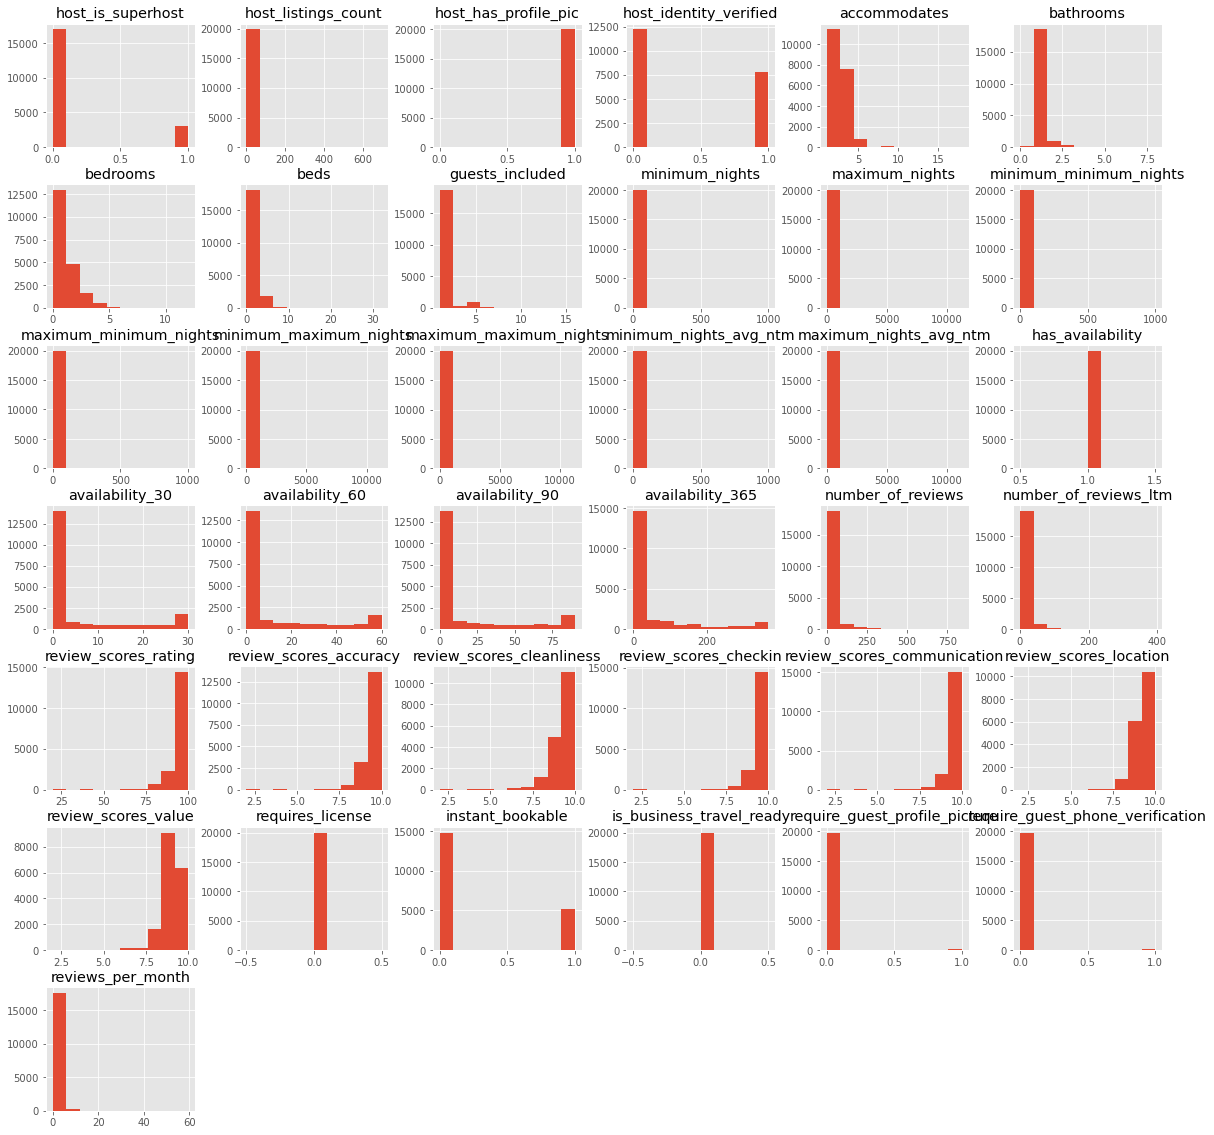

In [96]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [97]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 
         'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

# Data  Wrangelling - Cleanning stage

In [98]:
#Experiences_offered variable
df.experiences_offered.value_counts()
df.drop('experiences_offered', axis=1, inplace=True)

In [99]:
#host_since variable

df.host_since = pd.to_datetime(df.host_since) 

df['host_days_active'] = (pd.datetime(2020, 12, 30) - df.host_since).astype('timedelta64[D]')

print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 2094.0
Median days as host: 2145.0


In [100]:
#host_response_time
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

Null values: 9558
Proportion: 47.8%


unknown               0.477876
within an hour        0.265787
within a day          0.121694
within a few hours    0.117744
a few days or more    0.016899
Name: host_response_time, dtype: float64

In [101]:
#host_response_rate
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 9558
Proportion: 47.8%


In [102]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 76.4%


In [103]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    9558
100%       7982
50-89%     1394
0-49%       547
90-99%      520
Name: host_response_rate, dtype: int64

In [104]:
#host_is_superhost variable

df.dropna(subset=['host_since'], inplace=True)

In [105]:
# property_type variable
#Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories Apartment, House and Other will be used, as most properties can be classified as either apartment or house.

In [106]:
df.property_type.value_counts()

Apartment                 15189
House                      1676
Townhouse                   673
Bed and breakfast           427
Loft                        376
Condominium                 358
Boat                        339
Houseboat                   302
Guest suite                 161
Aparthotel                  105
Serviced apartment           62
Guesthouse                   49
Boutique hotel               39
Hotel                        35
Villa                        34
Other                        31
Hostel                       27
Tiny house                   17
Cottage                      12
Cabin                        11
Farm stay                     5
Bungalow                      4
Camper/RV                     2
Barn                          2
Chalet                        2
Island                        2
Yurt                          2
Campsite                      1
Castle                        1
Dome house                    1
Bus                           1
Lighthou

In [107]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [108]:
#bathrooms, bedrooms and beds variables
#Missing values will be replaced with the median (to avoid strange fractions).

for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [109]:
#bed_type variable
#Most listings have the same bed type, so it won't constitute a comparative advantage to have this feature. So this feature can be dropped.
df.bed_type.value_counts()

Real Bed         19790
Pull-out Sofa      105
Futon               36
Airbed              13
Couch                5
Name: bed_type, dtype: int64

In [110]:
df.drop('bed_type', axis=1, inplace=True)

In [111]:
#amenities
#Amenities is a list of additional features in the property, i.e. whether it has a TV or parking. Examples are below:
df.amenities[:1].values

array(['{Internet,Wifi,"Paid parking off premises","Buzzer/wireless intercom",Heating,Washer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Private entrance","Hot water","Bed linens","Extra pillows and blankets","Single level home","Garden or backyard","No stairs or steps to enter","Accessible-height bed","Host greets you","Handheld shower head","Paid parking on premises"}'],
      dtype=object)

In [112]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Barbecue utensils',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for 

In the list above, some amenities are more important than others (i.e. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (i.e.. 'Electric profiling bed'). For the purpose of this project, amenities will be extracted based on quick research into which amenities are considered by guests a selection of the more important as well as personal experience. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

In [113]:
#Amenities which we think are more informative:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [114]:
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'elevator', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [115]:
#price-based variables

In [116]:
for t in ['cleaning_fee','security_deposit']:
    df[t].fillna('$0.00', inplace=True)

In [117]:
col=['price','cleaning_fee','security_deposit','extra_people']
for t in col:
    df[t]=df[t].str.replace('$', '').str.replace(',', '').astype(float)  

In [118]:
#calendar_updated
df.drop('calendar_updated', axis=1, inplace=True)

In [119]:
#availability
#There are multiple different measures of availability, which will be highly correlated with each other
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [120]:
#first_review and last_review

Almost 20 percent of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information because reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an unknown category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [121]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 11.2%
Null values in 'review_scores_rating': 12.3%


In [122]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2020, 1, 1) - df.first_review).astype('timedelta64[D]')

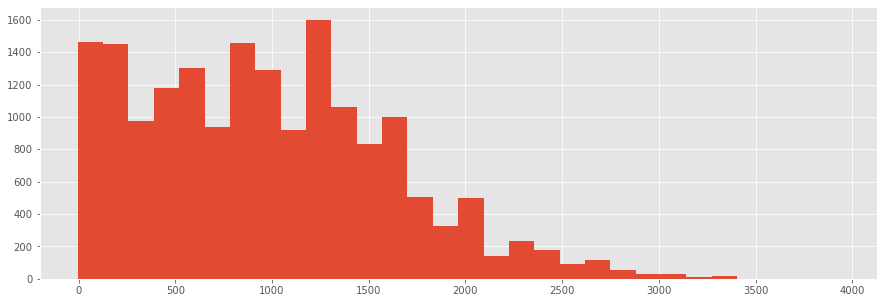

In [123]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [124]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [125]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

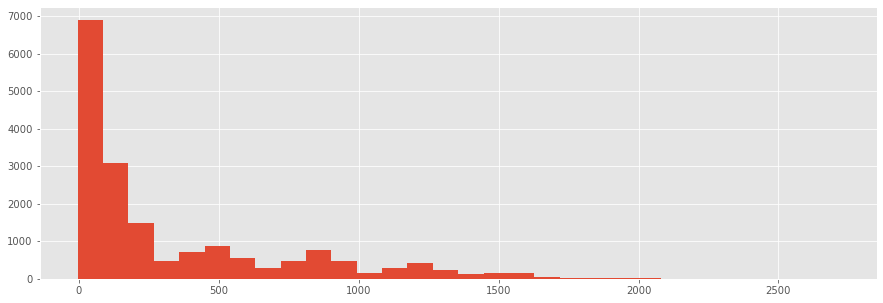

In [126]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2020, 1, 1) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [127]:
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [128]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

In [129]:
#review ratings variables

As above, listings without reviews will be kept and replaced with unknown. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating)

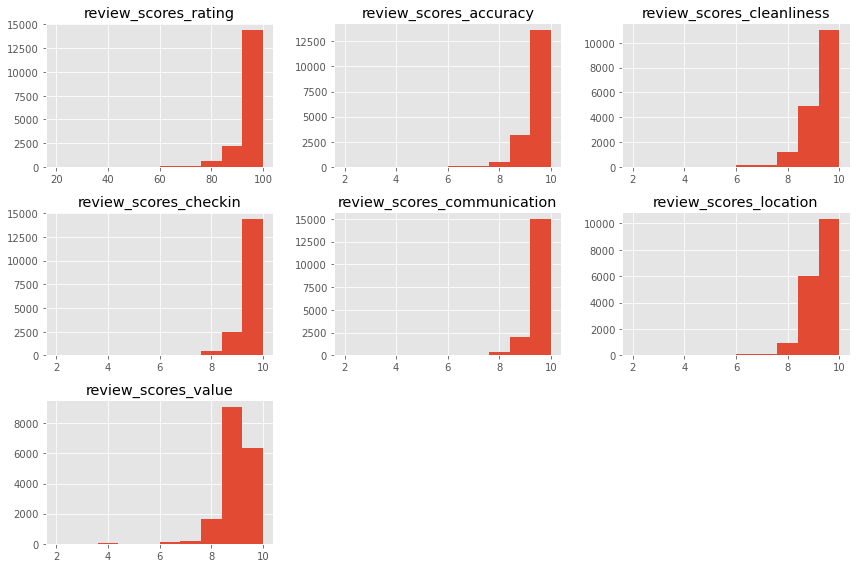

In [130]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [131]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [132]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [133]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [134]:
#cancellation_policy
#Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).
#df.cancellation_policy.value_counts()

In [135]:
# Replacing categories
#df.cancellation_policy.replace({
#    'super_strict_30': 'strict_14_with_grace_period',
#    'super_strict_60': 'strict_14_with_grace_period',
#    'strict': 'strict_14_with_grace_period',
#    'luxury_moderate': 'moderate'
#    }, inplace=True)

In [136]:
#number_of_reviews_ltm and reviews_per_month variables
#These will be highly correlated with number_of_reviews and so will be dropped

In [137]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [138]:
listings_cleaned = df.to_csv('listings_cleaned.csv', index=id, header=True)

# Exploratory Data Analysis

In [139]:
df = pd.read_csv('listings_cleaned.csv', index_col=0)

In [140]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [141]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008, and the most recent joined on 03 January 2020.


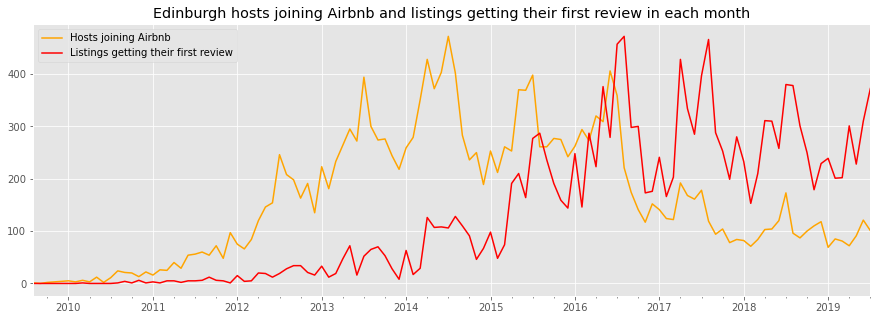

In [65]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Edinburgh hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-08-21', '2019-07-20') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [66]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [76]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    fig.savefig('time_seriess.jpg',
            format='jpg',
            dpi=100,
            bbox_inches='tight')

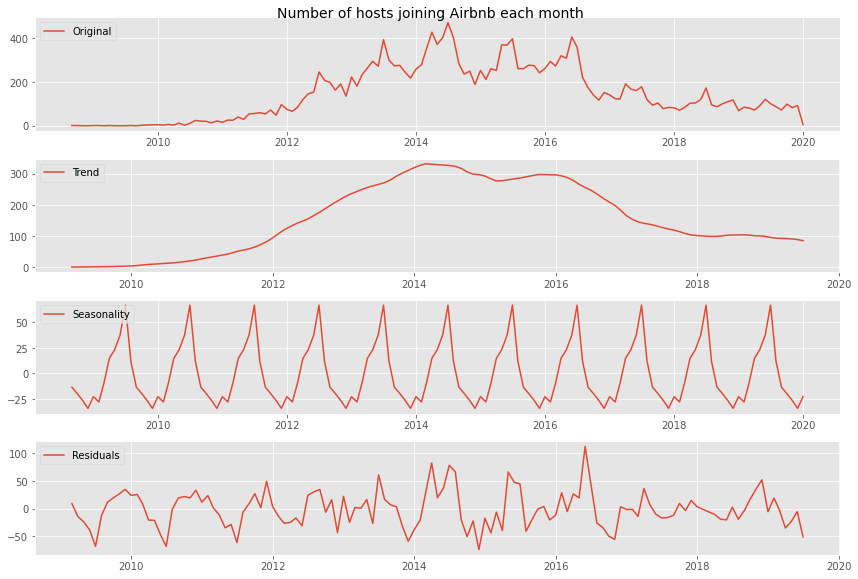

In [73]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

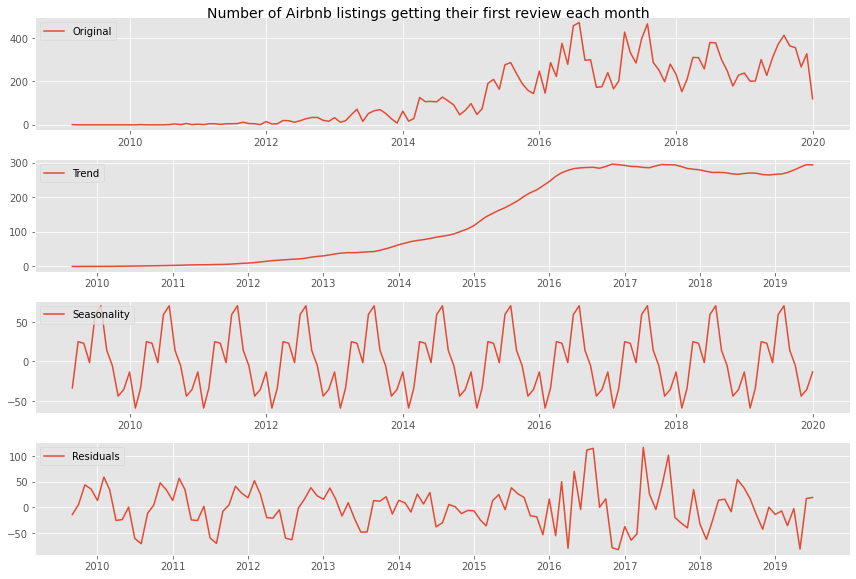

In [77]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

As seen above, there is a clear seasonality. Every year, you see a peak towards hosts joining around the middle of the year (summer), and the lowest points are the beginning and the end of each year. There is a big peak in the number of hosts joining Airbnb between 2014 and 2015. Indeed, there has been a fast growth of Airbnb since last months of 2014, with clear peaks during early monthes of 2015. This was the year when Airbnb became increasingly popular for short-term lease, as a way to get around local legislation and taxation. The same trend was observed in London, however, in London, the intriduction of the 90-day rule for short-term rentals is another variable to consider. That legislation did not apply to Edinburgh.

# EDA-Categorical Variables

Another important pattern to observe is the number of listings per owner/host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

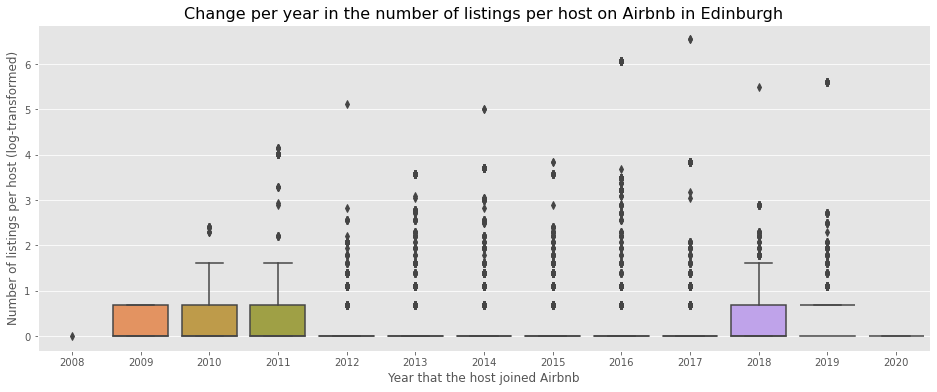

In [95]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Edinburgh', fontsize=16)
plt.show()

In [96]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
26511662,2014-04-29,41.0
17613029,2017-01-30,47.0
9849980,2011-12-02,56.0
19906167,2011-04-18,63.0
20613476,2014-08-12,149.0
26724522,2012-07-07,168.0
32852286,2018-07-12,242.0
38531529,2019-06-12,273.0
30434991,2016-06-06,435.0


In [97]:
print("Average number of listings per host per year on Airbnb in Edinburgh:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Edinburgh:
host_since
2008-01-01     0.50
2009-01-01     1.38
2010-01-01     2.34
2011-01-01     5.06
2012-01-01     1.55
2013-01-01     1.83
2014-01-01     1.80
2015-01-01     1.55
2016-01-01    12.53
2017-01-01     3.12
2018-01-01     2.12
2019-01-01     7.27
2020-01-01     0.40
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [98]:

# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
26511662,2014-04-29,41.0
17613029,2017-01-30,47.0
9849980,2011-12-02,56.0
19906167,2011-04-18,63.0
20613476,2014-08-12,149.0
26724522,2012-07-07,168.0
32852286,2018-07-12,242.0
38531529,2019-06-12,273.0
30434991,2016-06-06,435.0


In term of changes in prices over time, the average price per night for Airbnb listings in Edinburgh has increased slightly over the last 10 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median. The mean price in 2010 was £107.33 and the median £115.0, whereas the mean price in 2018 (the last complete year of data) was £104.55 and the median £79.0.

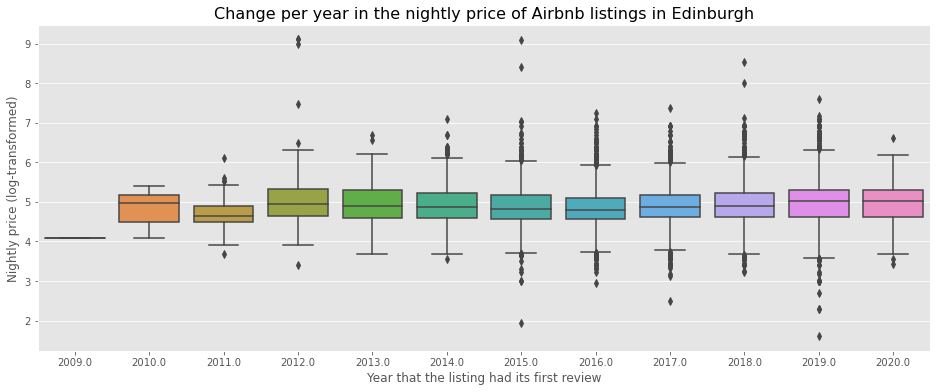

In [99]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Edinburgh', fontsize=16)
plt.show()

In [100]:
print("Mean nightly price of listings in each year on Airbnb in Edinburgh:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Edinburgh:
first_review
2009-01-01     59.00
2010-01-01    138.71
2011-01-01    125.57
2012-01-01    284.74
2013-01-01    160.65
2014-01-01    156.51
2015-01-01    154.27
2016-01-01    143.09
2017-01-01    148.45
2018-01-01    158.21
2019-01-01    172.04
2020-01-01    165.61
Name: price, dtype: float64


In [101]:
print("Median nightly price of listings in each year on Airbnb in Edinburgh:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year on Airbnb in Edinburgh:
first_review
2009-01-01     59.0
2010-01-01    145.0
2011-01-01    105.0
2012-01-01    140.0
2013-01-01    135.0
2014-01-01    130.0
2015-01-01    125.0
2016-01-01    120.0
2017-01-01    130.0
2018-01-01    135.0
2019-01-01    150.0
2020-01-01    150.0
Name: price, dtype: float64


In [102]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

# EDA-Numerical Variables

In [103]:
#price

Looking at price distribution, advertised prices range from £0 to £12,345. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site. Once you enter the dates you want to occupy the property, prices can vary a lot.

Unfortunately this model will be predicting advertised prices rather than the prices that were actually paid. Nonetheless, some cleaning of the particularly unhelpful values will be done. Very small values under £10 will be increased to £10.

There are notable drop-offs in prices at £200 (first graph, red line), £500 (second graph, green line) and £1,000 (second graph, red line). Values above £1,000 will be reduced to £1,000.

In [104]:
print(f"Advertised prices range from £{min(df.price)} to £{max(df.price)}.")

Advertised prices range from £0.0 to £9000.0.


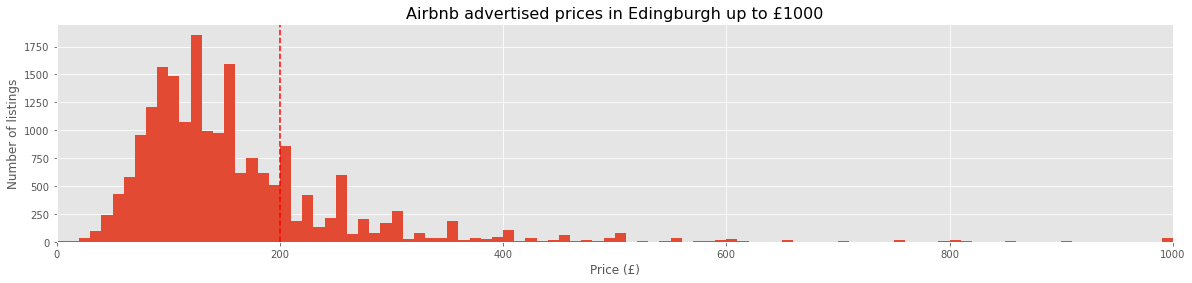

In [105]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Edingburgh up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

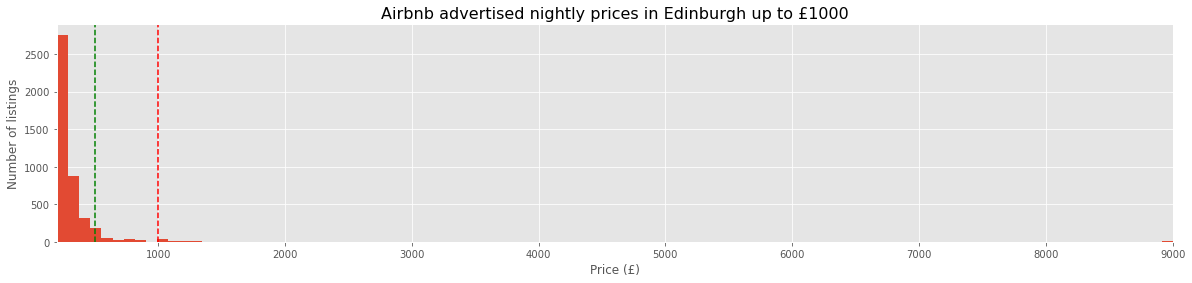

In [106]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Edinburgh up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [107]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

In [108]:
#host_listings_count

The median number of listings that the host of each listing has is 1. This means that on average (median) each listing is hosted by a host who only manages that listing. The mean is higher (8) due to some hosts managing some (very) large numbers of listings, as discussed above in the Time Series section. For example, the host with the highest number of listings has 1,058 listings under its ID. About half of listings are from hosts with one listing, and half are from multi-listing hosts.

Two difficulties in discerning how many listings hosts have on average are:

1) this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)

2) a host's other listings may not be in Edinburgh, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [109]:

print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(df.host_listings_count.max())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 4
Highest number of listins per host: 695
71% of listings are from hosts with one listing.


In [110]:
#accommodates, bathrooms, bedrooms and beds

The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher rates per night, with diminishing returns coming after about 10 people.

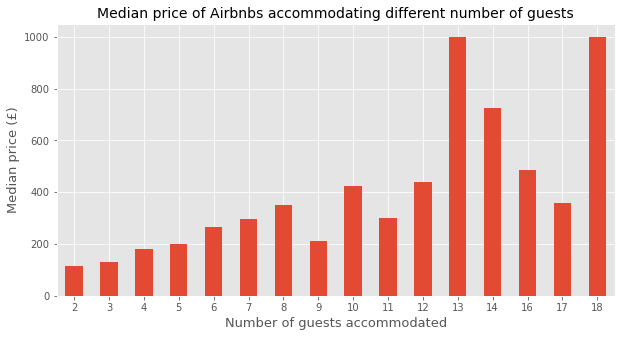

In [111]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

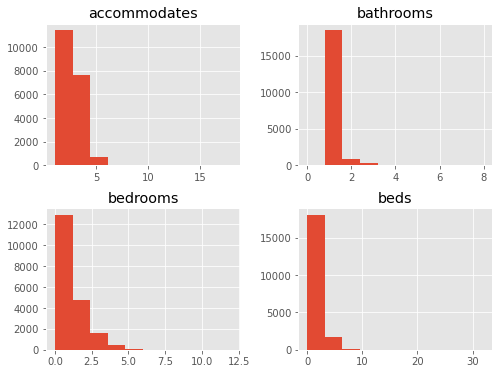

In [112]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

# Categorical Features

### Neighbourhood

Much of Airbnb listings are centred around Edinburgh's Old Town, which is consistent with the huge draw for tourists especially during the annual Fringe festival.

In [113]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Edinburgh borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Bijlmer-Oost,None,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4..."
1,Noord-Oost,None,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5..."
2,Noord-West,None,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4..."
3,Oud-Noord,None,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4..."
4,IJburg - Zeeburgereiland,None,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5..."


In [114]:
df.groupby('borough').size()

borough
Bijlmer-Centrum                            123
Bijlmer-Oost                               117
Bos en Lommer                             1151
Buitenveldert - Zuidas                     253
Centrum-Oost                              1737
Centrum-West                              2157
De Aker - Nieuw Sloten                     163
De Baarsjes - Oud-West                    3379
De Pijp - Rivierenbuurt                   2488
Gaasperdam - Driemond                      131
Geuzenveld - Slotermeer                    231
IJburg - Zeeburgereiland                   472
Noord-Oost                                 287
Noord-West                                 386
Oostelijk Havengebied - Indische Buurt     961
Osdorp                                     152
Oud-Noord                                  612
Oud-Oost                                  1319
Slotervaart                                422
Watergraafsmeer                            547
Westerpark                                1457
Zuid 

In [115]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)


In [116]:
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
Bijlmer-Oost,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...",117,70.0
Noord-Oost,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5...",287,110.0
Noord-West,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4...",386,120.0
Oud-Noord,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4...",612,125.0
IJburg - Zeeburgereiland,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5...",472,149.0


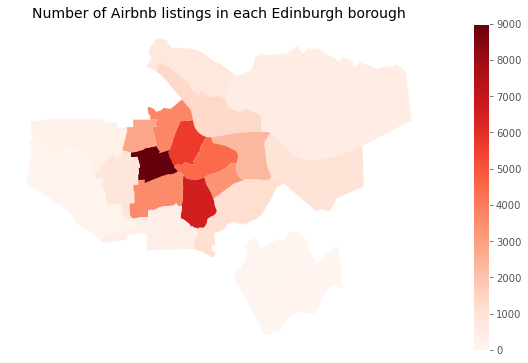

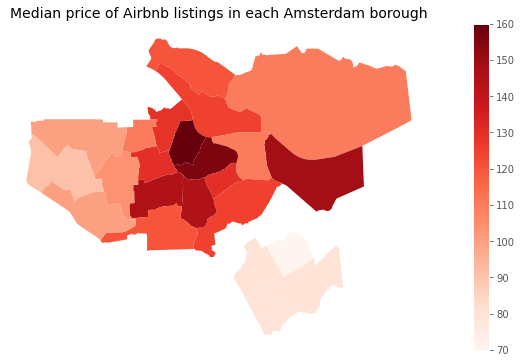

In [117]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Amsterdam borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

## property_type and room_type

In [118]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

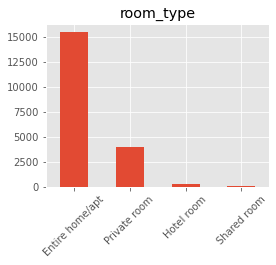

Entire home/apt    0.778736
Private room       0.202968
Hotel room         0.015590
Shared room        0.002707
Name: room_type, dtype: float64


In [119]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

#About 80% of properties are apartments/flats. The remainder are houses or more uncommon property types (e.g. bed and breakfast).

About 77% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

## review categories

For every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall). Ratings or 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, over a quarter of listings have not yet been reviewed.

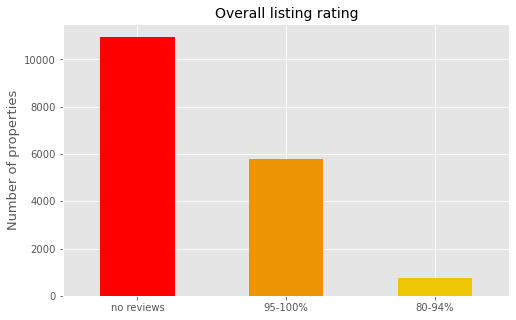

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['red', '#ed9405', '#edc605', '#ffec19' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

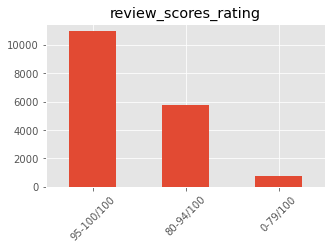

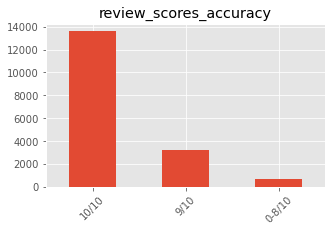

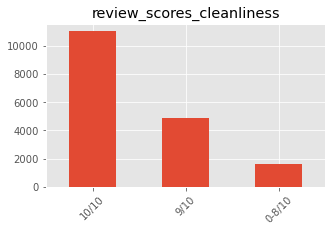

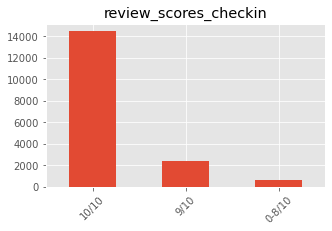

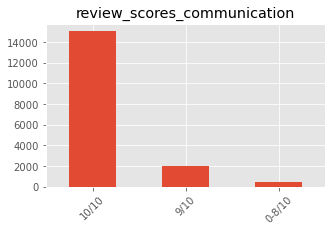

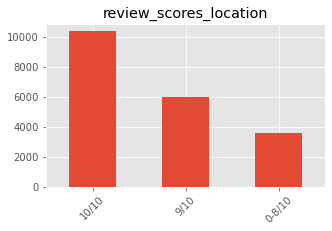

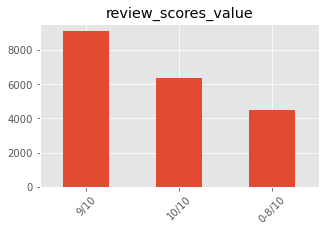

In [121]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

## first_review and last_review

The most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for more than four years, however.

The most common category for the time since a listing received its last review is 1+ years. This means that a lot of listings have not been reviewed recently. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book

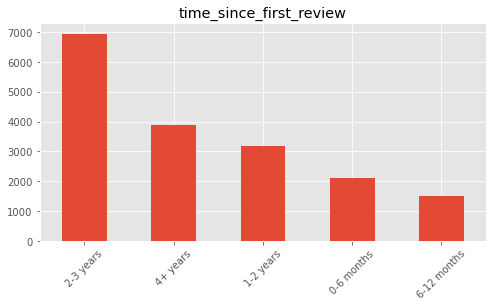

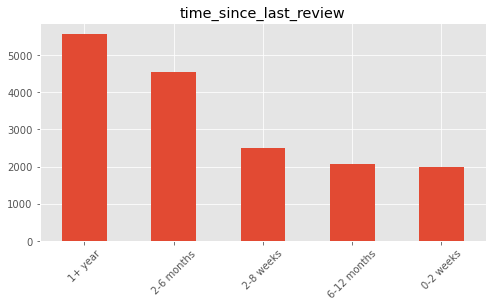

In [122]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

## Venue proximity

As part of our model, we are looking to explore proximity to certain venues as a possible price predictor. Walkability and ability to reach places maybe a deal-maker or breaker when it comes to choosing a accomodation. Proximity to certain venues, such as principal touristic attractions, restaurants, cafes and even shops could help us predict price. For this, we will use Foursquare API to explore the venues per neighbourhood. As discussed before, Old Town is the area which concentrates the majority of Airbnb listings.

We now retrieve the list of venues with their locations. We will use Foursquare API to explore the venues around the listings, using the latitude and longitude of each neighbourhood. We dill then find out which venues are the most common and select the most common venues as points of interest (POIS) for our accessibility analysis.

In [123]:
map_df.head()

,neighbourhood,geometry
0,Bijlmer-Oost,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4..."
1,Noord-Oost,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5..."
2,Noord-West,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4..."
3,Oud-Noord,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4..."
4,IJburg - Zeeburgereiland,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5..."


In [124]:
type(map_df.geometry)

geopandas.geoseries.GeoSeries

In [125]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [126]:
map_df.head()

,neighbourhood,geometry,longitude,latitude
0,Bijlmer-Oost,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...",4.977317,52.320279
1,Noord-Oost,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5...",5.003523,52.398339
2,Noord-West,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4...",4.894589,52.415306
3,Oud-Noord,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4...",4.910489,52.394068
4,IJburg - Zeeburgereiland,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5...",4.998377,52.360899


In [127]:
CLIENT_ID='AAATXYUCIIOIVJSMZ0X1EZHKOQ1BXZX5ZNJR4U4JXBI4KOV2'
CLIENT_SECRET='CNG1HL0442NZIVGVHDBRBWBWTJAEMCBLRR3V1P4MUZDIKBYN'
LIMIT=45
VERSION='20190101'
# Function to loop for venues through all neighbourhoods
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
ams_venues = getNearbyVenues(names=map_df['neighbourhood'],
                                   latitudes=map_df['latitude'],
                                   longitudes=map_df['longitude'],
                                 radius =1500
                                  )

Bijlmer-Oost
Noord-Oost
Noord-West
Oud-Noord
IJburg - Zeeburgereiland
Centrum-West
Oostelijk Havengebied - Indische Buurt
Centrum-Oost
Oud-Oost
Watergraafsmeer
Gaasperdam - Driemond
Westerpark
Bijlmer-Centrum
De Pijp - Rivierenbuurt
Zuid
Buitenveldert - Zuidas
De Baarsjes - Oud-West
Bos en Lommer
Geuzenveld - Slotermeer
Slotervaart
Osdorp
De Aker - Nieuw Sloten


In [129]:

#!pwd
# Saving Data set
ams_venues.to_csv('ams_Venues.csv')

In [130]:
ams_venues = pd.read_csv('ams_Venues.csv', index_col=0)

In [131]:
ams_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,South American Restaurant
1,Bijlmer-Oost,52.320279,4.977317,Kwakoe Festival,52.314200,4.961109,Park
2,Bijlmer-Oost,52.320279,4.977317,Gaasper Camping,52.312495,4.991548,Campground
3,Bijlmer-Oost,52.320279,4.977317,World Of Food,52.322949,4.956306,Food Court
4,Bijlmer-Oost,52.320279,4.977317,Diemerbos,52.330439,4.991331,Park


In [132]:
ams_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bijlmer-Centrum,45,45,45,45,45,45
Bijlmer-Oost,37,37,37,37,37,37
Bos en Lommer,45,45,45,45,45,45
Buitenveldert - Zuidas,45,45,45,45,45,45
Centrum-Oost,45,45,45,45,45,45
Centrum-West,45,45,45,45,45,45
De Aker - Nieuw Sloten,45,45,45,45,45,45
De Baarsjes - Oud-West,45,45,45,45,45,45
De Pijp - Rivierenbuurt,45,45,45,45,45,45


In [133]:
print('There are {} unique categories.'.format(len(ams_venues['Venue Category'].unique())))

There are 206 unique categories.


In [134]:
ams_venues.groupby('Venue Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
African Restaurant,1,1,1,1,1,1
Aquarium,1,1,1,1,1,1
Arcade,5,5,5,5,5,5
Art Gallery,3,3,3,3,3,3
Art Museum,1,1,1,1,1,1
...,...,...,...,...,...,...
Wine Bar,4,4,4,4,4,4
Wine Shop,1,1,1,1,1,1
Yoga Studio,6,6,6,6,6,6


In [136]:

# One Hot Encoding
ams_onehot = pd.get_dummies(ams_venues[['Venue Category']], prefix = "", prefix_sep = "")

## Add neighbourhood column back to df
ams_onehot['Neighbourhood'] = ams_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [ams_onehot.columns[-1]] + list(ams_onehot.columns[:-1])
ams_onehot = ams_onehot[fixed_columns]

# display
ams_onehot.head()

,Neighbourhood,African Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Brasserie,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,...,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shopping Mall,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Track,Trail,Tram Station,Tunnel,Turkish Restaurant,VR Cafe,Vegetarian / Vegan Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Bijlmer-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bijlmer-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bijlmer-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bijlmer-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bijlmer-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [137]:
#Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category
ams_grouped = ams_onehot.groupby('Neighbourhood').mean().reset_index()

In [138]:
ams_grouped.head() 

,Neighbourhood,African Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Brasserie,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,...,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shopping Mall,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Track,Trail,Tram Station,Tunnel,Turkish Restaurant,VR Cafe,Vegetarian / Vegan Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Bijlmer-Centrum,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022222,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.022222,0.000000,0.0,0.0,0.0,0.000000,0.022222,0.066667,0.0,0.000000,0.000000,0.000000,0.0,0.022222,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.088889,0.0,0.0,0.066667,...,0.000000,0.000000,0.0,0.0,0.000000,0.022222,0.000000,0.000000,0.000000,0.022222,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.0,0.0,0.022222,0.000000,0.000000,0.0,0.0,0.000000,0.022222,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.022222,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,Bijlmer-Oost,0.000000,0.0,0.027027,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.027027,0.0,0.0,0.0,0.081081,0.000000,0.000000,0.0,0.027027,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.054054,0.0,0.0,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.0,0.027027,0.0,0.0,0.000000,0.027027,0.000000,0.000000,0.027027,0.000000,0.0,0.0,0.000000,0.000000,0.027027,0.0,0.0,0.054054,0.000000,0.0,0.000000,0.000000,0.000000,0.027027,0.027027,0.0,0.000000,0.000000,0.000000,0.0,0.027027,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,Bos en Lommer,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022222,0.000000,0.0,0.0,0.0,0.000000,0.022222,0.0,0.0,0.000000,0.022222,0.000000,0.022222,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.022222,0.0,0.000000,0.000000,0.0,0.0,0.044444,0.0,0.000000,0.066667,0.0,0.0,0.000000,...,0.000000,0.044444,0.0,0.0,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000,0.022222,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.022222,0.000000,0.0,0.022222,0.000000,0.022222,0.000000,0.000000,0.0,0.000000,0.000000,0.022222,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,Buitenveldert - Zuidas,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.044444,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.022222,0.0,0.022222,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.022222,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.022222,0.0,0.0,0.000000,0.0,0.022222,0.00

In [139]:
#Get each neighbourhood along with its top 5 most common venues
num_top_venues = 5

for hood in ams_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = ams_grouped[ams_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bijlmer-Centrum----
            venue  freq
0           Hotel  0.13
1     Coffee Shop  0.09
2            Café  0.07
3  Soccer Stadium  0.07
4          Office  0.07


----Bijlmer-Oost----
         venue  freq
0         Park  0.14
1     Bus Stop  0.08
2   Restaurant  0.05
3  Supermarket  0.05
4   Print Shop  0.03


----Bos en Lommer----
          venue  freq
0          Café  0.07
1   Coffee Shop  0.07
2          Park  0.04
3  Climbing Gym  0.04
4    Restaurant  0.04


----Buitenveldert - Zuidas----
            venue  freq
0           Hotel  0.11
1             Gym  0.04
2     Snack Place  0.04
3  Sandwich Place  0.04
4     Supermarket  0.04


----Centrum-Oost----
            venue  freq
0           Hotel  0.07
1    Cocktail Bar  0.04
2  Breakfast Spot  0.04
3  History Museum  0.04
4     Record Shop  0.04


----Centrum-West----
                venue  freq
0               Hotel  0.16
1      Sandwich Place  0.07
2                 Bar  0.07
3           Hotel Bar  0.04
4  Italian Restauran

In [140]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [141]:
# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = ams_grouped['Neighbourhood']

for ind in np.arange(ams_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ams_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bijlmer-Centrum,Hotel,Coffee Shop,Soccer Stadium,Café,Concert Hall
1,Bijlmer-Oost,Park,Bus Stop,Restaurant,Supermarket,Buffet
2,Bos en Lommer,Café,Coffee Shop,Park,Climbing Gym,Restaurant
3,Buitenveldert - Zuidas,Hotel,Spa,Gym,Gym / Fitness Center,Snack Place
4,Centrum-Oost,Hotel,Breakfast Spot,History Museum,Bar,Record Shop


In [142]:
#Let's look at how many categories are on the 1st most common venue.
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 12 unique categories.


In [143]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

,Neighbourhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1st Most Common Venue,,,,,
Bus Stop,1,1,1,1,1
Café,3,3,3,3,3
Campground,1,1,1,1,1
Coffee Shop,3,3,3,3,3
Dance Studio,1,1,1,1,1
French Restaurant,1,1,1,1,1
Hotel,6,6,6,6,6
Lake,1,1,1,1,1
Park,2,2,2,2,2



From above, we observe that the most common venues across the dataset are Hotel, Pub, Grocery Store, Supermarket, Cafe, Coffee Shop, with Bar, Bus Stop and Indian Restaurant coming behind. It is clear that different restaurant venues are in subcategories which makes them less common than if they were aggregated. Thus, for the purpose accounting for the venues that may have the most impact on price, we will limit the venues to the most common categories. It is unlikely that having a hotel nearby will affect price, as Airbnb listings are considered to be on a different category of short-term rental, due to the different benefits they provide versus hotels. Thus, that category of venues will not be considered.

# Walkability to nearest venues

We will use this information on venues to select Points of Interest for which we will graph and measure access to each one. For this purpose, we will use OSMnx and Pandana libraries.

Pandana is a handy graph library that allows for Pandas data frames to be passed through into a network graph that maps graph-level analyses to underlying C operations. All of this is to say, it's much faster than traditional Python-based graphs, such as NetworkX.

In certain situations, such as the performance of accessibility analyses, this makes in-memory performance and iterative development based on this library possible, as opposed to what would be a cumbersome development process with tools that fail to leverage the same degree of C-level operations utilization.

### Points of interest (POIs) and network data from OSM
We now get the points of interest. For our case, we already have the POIS retrieved using the Foursquare API. As we found out in the previous section, Pubs, Restaurants, Cafes and Supermarkets/Grocery Stores are our POIS.

In [144]:
# same with Edinburghvenues
ams_venues['Venue Category'].value_counts()

Hotel                 54
Coffee Shop           37
Café                  35
Restaurant            33
Park                  30
                      ..
Spanish Restaurant     1
Roof Deck              1
Warehouse Store        1
Tour Provider          1
Multiplex              1
Name: Venue Category, Length: 206, dtype: int64

In [145]:
start_time = time.time()

# Points of interest already exists. Load from edinburgh_venues
df_pois = ams_venues.copy()
terms = ['Grocery Store', 'Bar', 'Pub', 'Restaurant', 'Café']
df_pois = df_pois[df_pois['Venue Category'].str.contains('|'.join(terms))]
df_pois.to_csv('foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'

print('{:,} POIs {} in {:,.2f} seconds'.format(len(df_pois), method, time.time()-start_time))
df_pois.head()

273 POIs loaded from CSV in 0.01 seconds


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,South American Restaurant
6,Bijlmer-Oost,52.320279,4.977317,Stick-up Indo food,52.322770,4.956669,Satay Restaurant
9,Bijlmer-Oost,52.320279,4.977317,Meram Zuidoost,52.322668,4.974577,Turkish Restaurant
30,Bijlmer-Oost,52.320279,4.977317,Picnic Fulfillmentcentrum,52.331448,4.984601,Grocery Store
33,Bijlmer-Oost,52.320279,4.977317,Bar,52.315189,4.995889,Restaurant


In [146]:
# Making sure each variable's type makes sense
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
dtype: object

In [147]:
# how many points of interest of each type of amenity did we retrieve?
df_pois['Venue Category'].value_counts()

Café                             35
Restaurant                       33
Bar                              25
Italian Restaurant               21
Turkish Restaurant               16
French Restaurant                12
Grocery Store                    12
Indonesian Restaurant            10
Chinese Restaurant                8
Thai Restaurant                   7
Fast Food Restaurant              7
Japanese Restaurant               6
Seafood Restaurant                5
Cocktail Bar                      5
Wine Bar                          4
South American Restaurant         4
Greek Restaurant                  4
Middle Eastern Restaurant         4
Hotel Bar                         4
Beer Bar                          3
Australian Restaurant             3
Vegetarian / Vegan Restaurant     3
Sushi Restaurant                  3
Mediterranean Restaurant          3
Comfort Food Restaurant           3
Pub                               3
Ethiopian Restaurant              3
Falafel Restaurant          

In [148]:
# Put all restaurant, bar and pub venues together under same name
df_pois.loc[df_pois['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
df_pois.loc[df_pois['Venue Category'].str.contains('Bar', case=False), 'Venue Category'] = 'Bar'
df_pois.loc[df_pois['Venue Category'].str.contains('Pub', case=False), 'Venue Category'] = 'Pub'
df_pois['Venue Category'].value_counts()

Restaurant       181
Bar               42
Café              35
Grocery Store     12
Pub                3
Name: Venue Category, dtype: int64

In [149]:
# configure filenames to save/load network datasets

# Edinburgh's bounding box found here: https://boundingbox.klokantech.com/
bbox = [52.338695,4.795532,52.401581 ,4.976807] 

bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)

In [150]:
start_time = time.time()

# query the OSM API for the street network within the specified bounding box
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
method = 'downloaded from OSM'

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](52.33869500,4.79553200,52.40158100,4.97680700);>;);out;'}"
Downloaded 17,716.8KB from www.overpass-api.de in 4.30 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 5.05 seconds
Returning OSM data with 102,665 nodes and 32,875 ways...
Edge node pairs completed. Took 55.12 seconds
Returning processed graph with 41,048 nodes and 61,404 edges...
Completed OSM data download and Pandana node and edge table creation in 63.59 seconds


In [151]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

# remove low-connectivity nodes and save to h5
network.save_hdf5('mynetwork.h5',rm_nodes=lcn)

In [152]:
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 41,048 nodes downloaded from OSM in 1,264.96 secs


When saving a Network to HDF5 it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the low_connectivity_nodes() method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

### Calculate accessibility to any amenity we retrieved
This is where conducting geographical analysis in Python shows its power, as opposed to sitting in front of a GIS package. Pandana is built for speed. First, we'll pass it a maximum search distance. This allows a key step that speeds up future enquiries: Pandana will build a condensed representation of the network (implemented in C++), allowing rapid calculations within a defined radius of each node. We then, build a table of distances to the nearest 5 points of interest from a couple of intersections. When this is finished, accessibility analyses for different selected amenities can be done in under a second. (Behind the scenes, two algorithms make this possible: contraction hierarchies and kd-trees.

In [153]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10
num_categories = len(df_pois['Venue']) + 1 #one for each amenity, plus one extra for all of them combined

In [154]:
## precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [155]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [156]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
# with Edinburgh_Venues subset df_pois
network.set_pois(category='all', x_col = df_pois['Venue Longitude'], y_col = df_pois['Venue Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [157]:
# searches for the n-nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returns a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head() # Distance in meters to ten nearest amenities

41,048 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
6316199,490.130005,589.250977,606.914001,869.200989,911.007019,912.033997,945.869995,1000.000000,1000.000000,1000.000000
25596455,401.718994,588.489014,627.497009,627.497009,633.664978,657.005005,944.340027,965.463989,975.619995,975.619995
25596477,348.842987,357.871002,367.276001,373.855011,468.391998,472.890015,537.820007,562.580017,562.905029,706.820984
25645930,89.844002,267.903992,267.903992,295.833008,324.265015,389.807007,609.317993,609.317993,660.195984,672.012024
25645931,93.568001,249.796997,249.796997,279.662994,374.651001,440.192993,591.210999,591.210999,642.088989,653.905029


In [158]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Reds', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Reds'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Reds', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

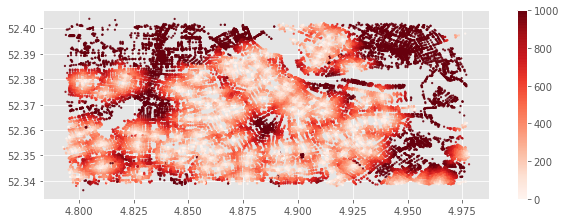

ValueError: not enough values to unpack (expected 3, got 2)

In [159]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs,cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Edinburgh', fontsize=15)
fig.savefig('/resources/Data_Science_Capstone/accessibility-Edinburgh.png', dpi=200, bbox_inches='tight')

As seen above, there are some zones where people have to walk more than 500 meters to reach the nearest amenity, whereas in Edinburgh's Old Town has walking distances of less than 100 meters on average.

The map shows the walking distance in meters from each network node to the nearest restaurant, bar, cafe, pub and Grocery shop. But, a better indicator of accessibility might be having access to a large number of amenities. So instead of the nearest, we plot accessibility to the fifth-nearest amenity:

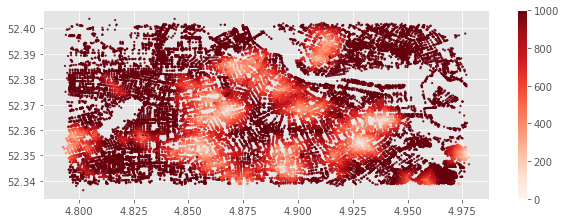

(<Figure size 720x249.775 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x270818ade50>)

In [160]:
# distance to the 5th nearest amenity of any type
n = 5
network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                              cbar_kwargs=cbar_kwargs)

This time, is even more noticeable that Old Town and the city center area od Edinburgh is more accessible.

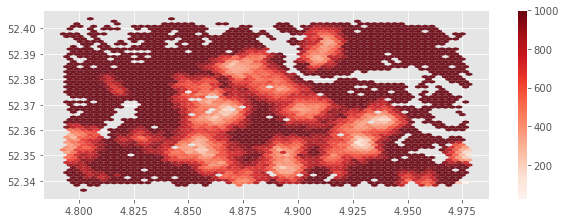

ValueError: not enough values to unpack (expected 3, got 2)

In [161]:
# distance to the 5th nearest amenity of any type, as hexbins
n=5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs,  cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Edinburgh', fontsize=15)
fig.savefig('accessibility-hexbins-ams.png', dpi=200, bbox_inches='tight')

Accessibility scores can quickly be constructed to answer a given question: whether it’s access to essential services, or walkable neighborhoods that appeal to young workers. For our purposes, access to restaurants, shops, cafes, bars and pubs are taken as essential for Airbnb users. So we are weighting all amenities equally and using distance to the fifth nearest amenity as a compound measure of accessibility. This gives a clearer picture of which neighborhoods are most walkable, compared with plotting just the distance to the single nearest venue/amenity.

In [162]:
n = 5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Edinburgh', fontsize=15)
fig.savefig('accessibility-nearest5th-ams.png', dpi=200, bbox_inches='tight')

TypeError: plot() got an unexpected keyword argument 'bmap_kwargs'

### Setting distance to the fifth nearest amenity as a compound measure of accessibility

In [163]:
# retreive the 5th nearest amenities (of all types) to each node in the network
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the 5 POIs
print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access_Score.head()

41,048 nodes


,5
id,
6316199,911.007019
25596455,633.664978
25596477,468.391998
25645930,324.265015
25645931,374.651001


### Network aggregation

Here, we combine Score, our compound measure of accessibility (network distance from the node to the 5th nearest POIs) with the POIs dataset df_pois.

In [164]:
Access = Access_Score.rename(columns={5:'Score'})
Access.head()
Access.dtypes

Score    float64
dtype: object

In [165]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Venue Longitude'], df_pois['Venue Latitude'])
df_pois.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,node_ids
0,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955
6,Bijlmer-Oost,52.320279,4.977317,Stick-up Indo food,52.322770,4.956669,Restaurant,7358355035
9,Bijlmer-Oost,52.320279,4.977317,Meram Zuidoost,52.322668,4.974577,Restaurant,4842526955
30,Bijlmer-Oost,52.320279,4.977317,Picnic Fulfillmentcentrum,52.331448,4.984601,Grocery Store,4842527001
33,Bijlmer-Oost,52.320279,4.977317,Bar,52.315189,4.995889,Restaurant,4842527001


In [166]:
#pois_sub.reset_index(level=0, inplace=True) # convert index into column
Access.reset_index(level=0, inplace=True)

In [167]:
# Set both columns to have the same names
Access = Access.rename(columns={'id':'node_ids'})
Access.head()

,node_ids,Score
0,6316199,911.007019
1,25596455,633.664978
2,25596477,468.391998
3,25645930,324.265015
4,25645931,374.651001


In [168]:
# Merging by node_ids
merged = pd.merge(df_pois, Access, on='node_ids')

In [169]:
# Checking column types make sense
merged.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
node_ids                     int64
Score                      float64
dtype: object

In [170]:
merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,node_ids,Score
0,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955,220.160995
1,Bijlmer-Oost,52.320279,4.977317,Meram Zuidoost,52.322668,4.974577,Restaurant,4842526955,220.160995
2,Gaasperdam - Driemond,52.303315,4.990531,Lucky Garden,52.295101,4.976852,Restaurant,4842526955,220.160995
3,Gaasperdam - Driemond,52.303315,4.990531,Toko Reigersbos,52.297571,4.974995,Grocery Store,4842526955,220.160995
4,Bijlmer-Oost,52.320279,4.977317,Stick-up Indo food,52.322770,4.956669,Restaurant,7358355035,777.590027


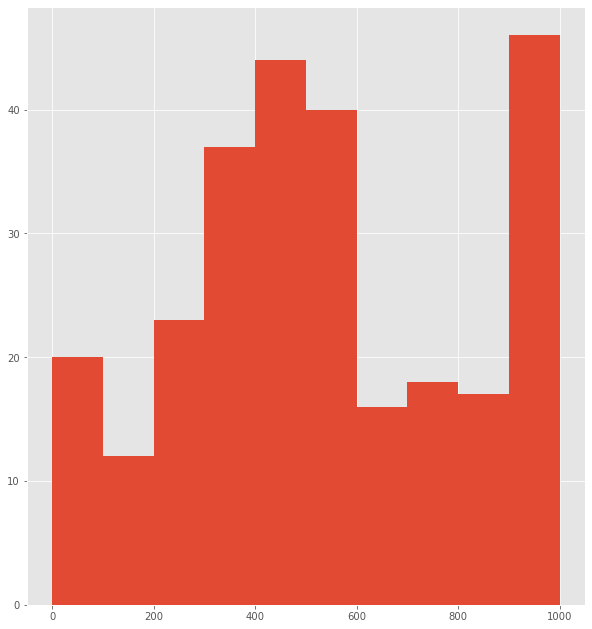

In [171]:
merged['Score'].hist(figsize=(10,11))

In [172]:
# Setting both columns have the same name for merging
df = df.rename(columns={'borough': 'Neighbourhood'})

In [173]:
# Merging by neighbourhoods
df_merged = pd.merge(merged, df, on='Neighbourhood')

In [174]:
# Save cleaned for modelling
df_merged.to_csv('listings_model.csv', index=id, header=True)

In [175]:
df_merged = pd.read_csv('listings_model.csv', index_col=0)
df_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,node_ids,Score,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,host_days_active,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,time_since_first_review,time_since_last_review
0,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955,220.160995,within a few hours,100%,1.0,1.0,1.0,House,Entire home/apt,5,1.5,3.0,5.0,225.0,750.0,95.0,4,89.0,1,30,1,1,30,30,1.0,30.0,90,64,95-100/100,10/10,9/10,10/10,10/10,9/10,9/10,0,3127.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,NaN
1,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955,220.160995,within an hour,100%,1.0,1.0,1.0,Apartment,Private room,2,1.0,1.0,1.0,65.0,100.0,20.0,1,0.0,2,60,2,2,60,60,2.0,60.0,19,318,95-100/100,10/10,10/10,10/10,10/10,9/10,10/10,1,3369.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,4+ years,2-8 weeks
2,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955,220.160995,unknown,unknown,0.0,1.0,1.0,House,Entire home/apt,5,1.0,4.0,4.0,90.0,0.0,0.0,1,0.0,5,18,5,5,18,18,5.0,18.0,0,2,80-94/100,10/10,10/10,10/10,10/10,0-8/10,9/10,0,2404.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4+ years,1+ year
3,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955,220.160995,unknown,unknown,0.0,1.0,0.0,Apartment,Entire home/apt,2,1.0,1.0,1.0,50.0,150.0,25.0,1,0.0,3,120,3,3,120,120,3.0,120.0,0,3,95-100/100,10/10,10/10,10/10,10/10,9/10,10/10,0,2369.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,1+ year
4,Bijlmer-Oost,52.320279,4.977317,De Smeltkroes,52.322755,4.974752,Restaurant,4842526955,220.160995,unknown,unknown,0.0,1.0,0.0,House,Private room,2,1.0,1.0,1.0,45.0,0.0,0.0,1,0.0,2,1125,2,2,1125,1125,2.0,1125.0,0,23,80-94/100,9/10,0-8/10,9/10,9/10,0-8/10,0-8/10,0,2145.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4+ years,1+ year


In [176]:
df_merged.drop(['Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Neighbourhood Latitude',
               'Venue Category', 'node_ids', 'Venue'], axis=1, inplace=True)

In [177]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311031 entries, 0 to 311030
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Neighbourhood                311031 non-null  object 
 1   Score                        311031 non-null  float64
 2   host_response_time           311031 non-null  object 
 3   host_response_rate           311031 non-null  object 
 4   host_is_superhost            311031 non-null  float64
 5   host_listings_count          311031 non-null  float64
 6   host_identity_verified       311031 non-null  float64
 7   property_type                311031 non-null  object 
 8   room_type                    311031 non-null  object 
 9   accommodates                 311031 non-null  int64  
 10  bathrooms                    311031 non-null  float64
 11  bedrooms                     311031 non-null  float64
 12  beds                         311031 non-null  float64
 13 

In [178]:
transformed_df = pd.get_dummies(df_merged)


In [179]:
transformed_df.shape

(311031, 109)

In [91]:
transformed_df.to_csv('big_data.csv')

(314397, 19277)

Areas of multi-collinearity:

Beds, bedrooms, guests_included and the number of people that a property accommodates are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates.

Unsurprisingly, there are perfect correlations between NaN reviews (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. NaN categories can therefore be dropped.

The same is true of host_response_rate_unknown and host_response_time_unknown. One of these rates will be dropped.

There is a correlation between host_response_rate 0-49% and host_response_time_a few days or more. One of these will be dropped.

There are strong negative correlations between property_type_House and property_type_Apartment, and between room_type_Private room and room_type_Entire_home_apt (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [180]:
transformed_df.corr()

,Score,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_90,number_of_reviews,instant_bookable,host_days_active,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,Neighbourhood_Bijlmer-Centrum,Neighbourhood_Bijlmer-Oost,Neighbourhood_Bos en Lommer,Neighbourhood_Buitenveldert - Zuidas,Neighbourhood_Centrum-Oost,Neighbourhood_Centrum-West,Neighbourhood_De Aker - Nieuw Sloten,Neighbourhood_De Baarsjes - Oud-West,Neighbourhood_De Pijp - Rivierenbuurt,Neighbourhood_Gaasperdam - Driemond,Neighbourhood_Geuzenveld - Slotermeer,Neighbourhood_IJburg - Zeeburgereiland,Neighbourhood_Noord-Oost,Neighbourhood_Noord-West,...,Neighbourhood_Oud-Oost,Neighbourhood_Slotervaart,Neighbourhood_Watergraafsmeer,Neighbourhood_Westerpark,Neighbourhood_Zuid,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_communication_0-8/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
Score,1.000000,0.022479,0.016987,-0.018968,0.027481,0.013818,0.014219,0.026799,0.020517,-0.000477,-0.001679,0.015492,0.008582,-0.004695,-0.002238,-0.004693,-0.003996,-0.005928,-0.003098,-0.004387,-0.004597,0.050308,0.026274,0.036157,-0.033619,-0.011026,0.017520,-0.016813,0.010974,-0.001274,-0.027770,-0.002944,0.048535,0.012849,-0.006572,0.032434,0.004193,0.019044,0.006260,0.086379,-0.065153,0.158680,0.080783,0.105027,0.162140,0.142082,-0.363002,-0.055246,-0.063387,0.161909,-0.110928,0.068114,0.137012,...,-0.060861,0.101907,0.053832,-0.007130,0.080693,0.008727,-0.034735,-0.005452,0.006508,0.036659,0.004813,0.021196,0.009806,0.024769,-0.034735,-0.071332,0.053311,0.042004,-0.043644,0.018235,0.038652,0.006709,0.006525,0.009256,-0.022744,0.006696,-0.021559,0.008133,0.008610,-0.013133,-0.003834,0.000635,-0.015026,0.002560,0.003081,-0.020724,0.008187,0.032434,-0.034268,0.010554,0.013289,-0.015691,0.003586,0.011690,0.003197,-0.015100,-0.017236,0.013501,0.016641,-0.025863,-0.002672,0.011489,-0.013379
host_is_superhost,0.022479,1.000000,-0.026242,0.037732,-0.010917,0.024384,-0.051922,-0.006179,0.007890,0.003871,-0.006907,0.046279,0.047659,-0.006703,-0.046964,-0.009376,-0.003853,-0.028972,-0.028592,-0.005686,-0.029955,0.177422,0.362051,0.077973,0.030156,0.130628,0.165047,-0.053463,0.228271,0.142063,-0.088409,0.004132,0.159870,0.147537,0.027415,0.125311,0.016513,0.050608,0.052416,0.004232,0.002641,-0.013721,-0.004826,0.05193

In [186]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

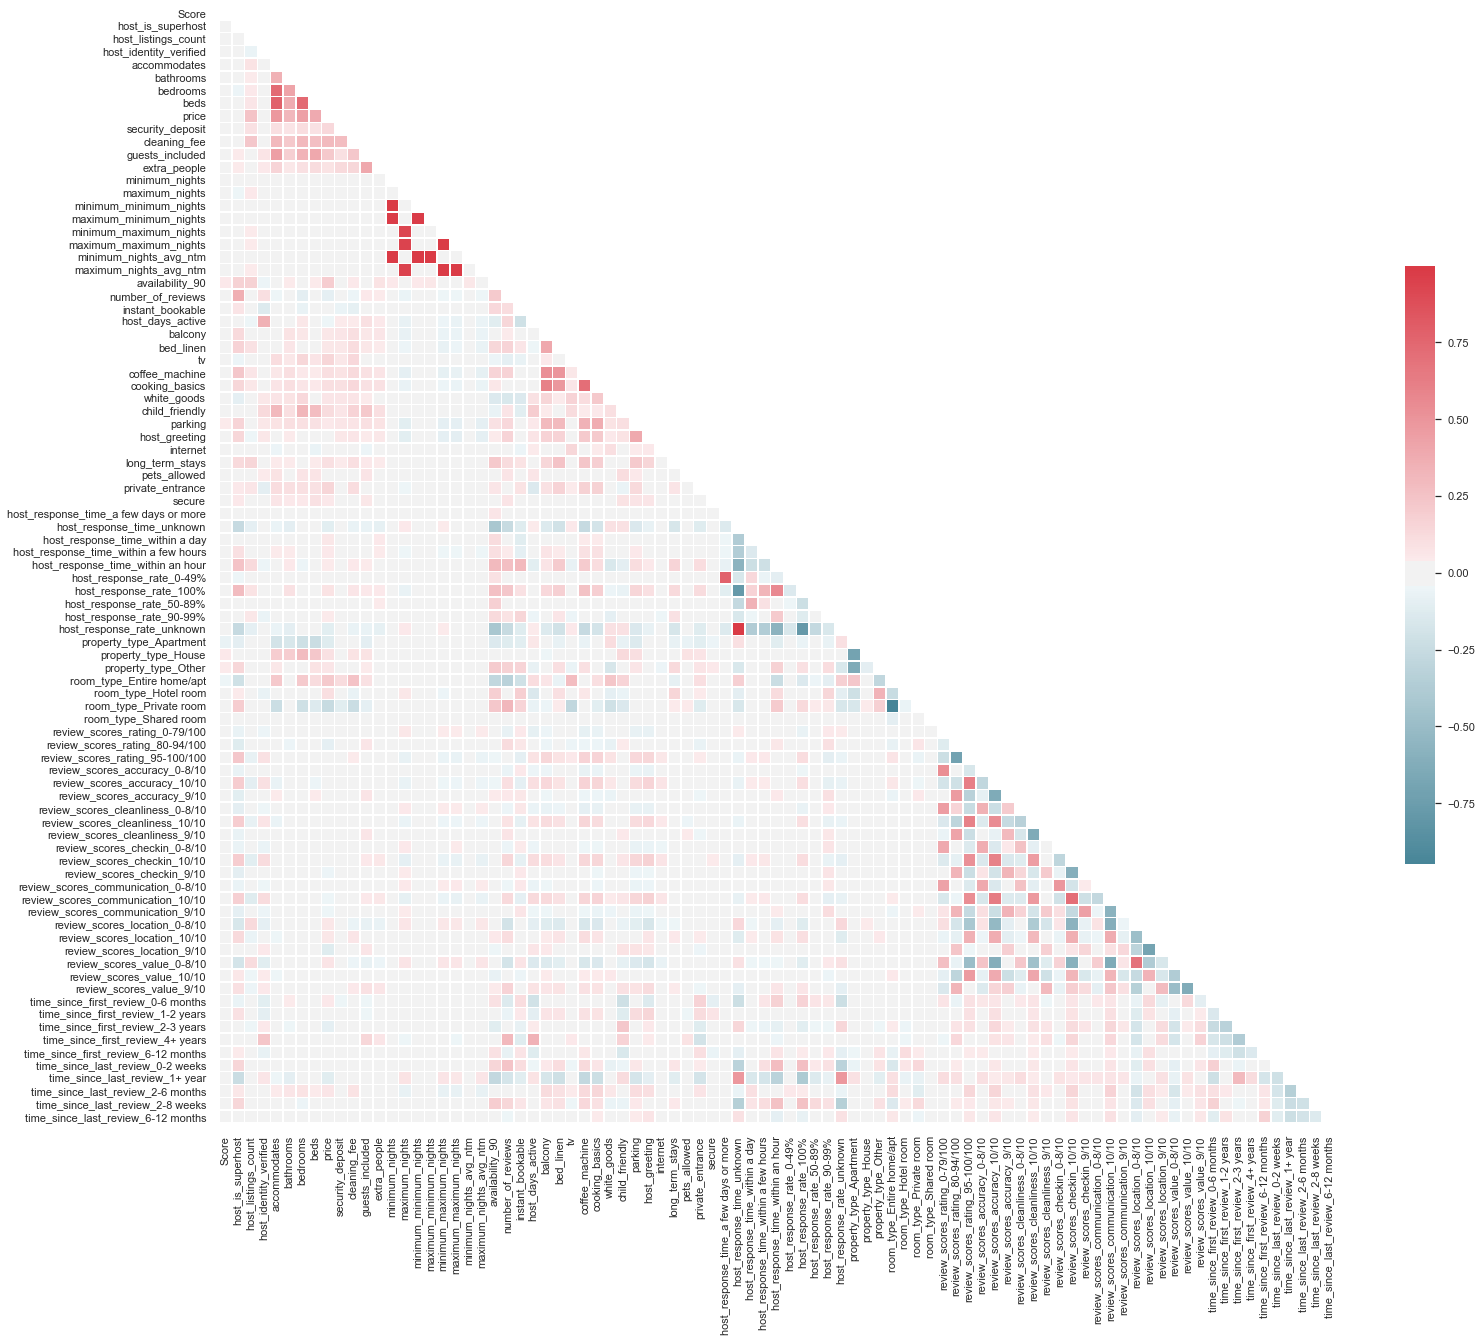

In [187]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

In [188]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room',
         'maximum_minimum_nights',
          'maximum_maximum_nights',
          'minimum_maximum_nights',
          'maximum_minimum_nights']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

## Standardising and normalising

Other than availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation

In [190]:
numerical_columns = ['Score','accommodates', 'availability_90', 'bathrooms',
                     'cleaning_fee', 'extra_people', 'host_days_active', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

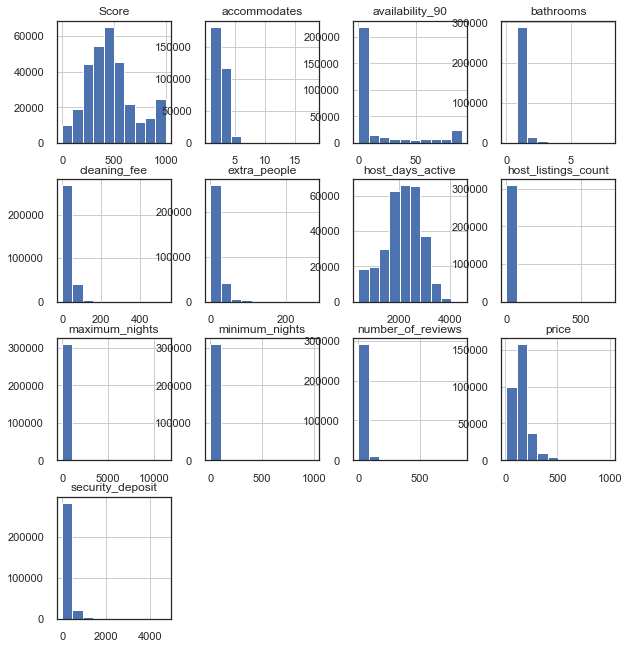

In [191]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [192]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. cleaning_fee, extra_people fee and security_fee) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

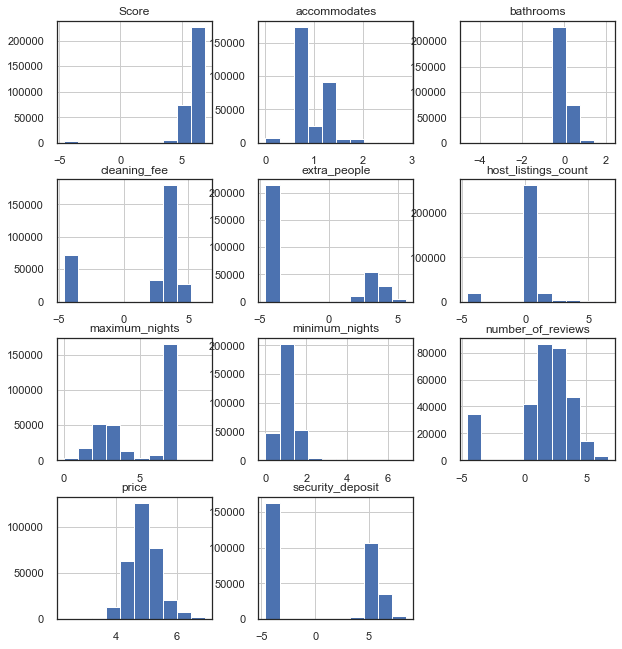

In [193]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features X and the target feature y can be separated, and X will be scaled. StandardScaler from sklearn will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

That is, we’ll separate the features and the target variable for modeling. We will assign the features (explanatory variables) to X and the target variable to y. We use scaler.fit_transform(), as mentioned above, to transform the y variable for the model. transformed_df.drop([features], axis=1) tells pandas which columns we want to exclude. We won’t include price for obvious reasons, and ID is just an index with no relationship to price.

In [194]:
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [197]:
hpm_reg_start = time.time()
hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.1 minutes

Training RMSE: 0.1248
Validation RMSE: 0.1243

Training r2: 0.521
Validation r2: 0.5203


In [198]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,4.094345,4.079222
1,4.867534,5.113248
2,4.828314,4.685222
3,4.787492,4.894173
4,5.081404,4.843659
...,...,...
62202,4.820282,4.771503
62203,4.382027,4.441747
62204,4.174387,4.600866
62205,4.007333,4.179764


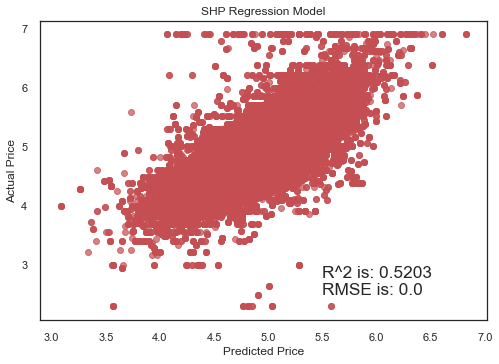

In [201]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

Improving our model
We can try using Ridge Regularization to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

We’ll once again instantiate the model. The Ridge Regularization model takes a parameter, alpha , which controls the strength of the regularization.

We’ll experiment by looping through a few different values of alpha, and see how this changes our results.

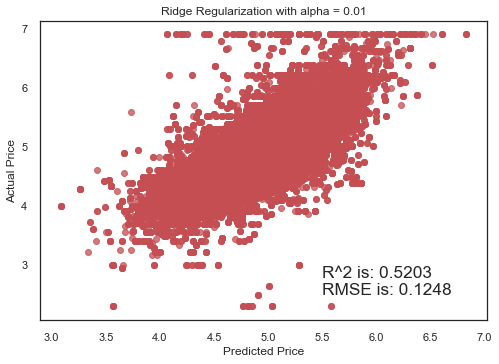

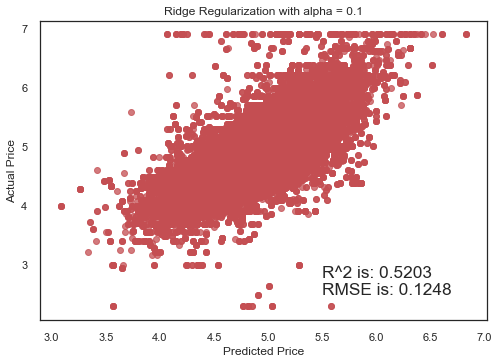

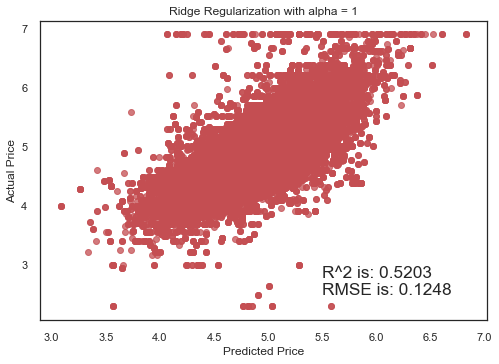

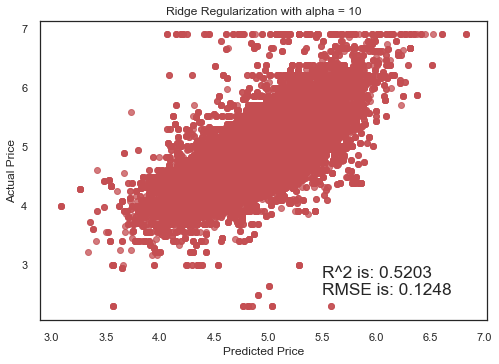

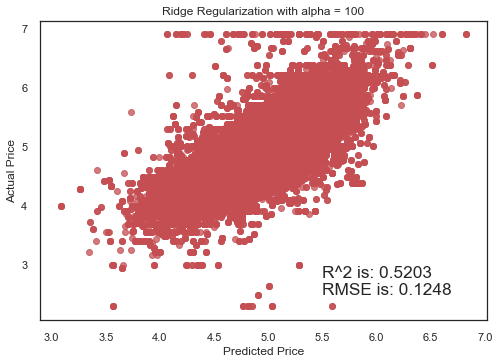

In [202]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

Model 2: Gradient boosted decision trees
Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

XGBoost (eXtreme Gradient Boosting) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

This approach supports both regression and classification predictive modeling problems. For more information see here to listen to Tianqi Chen, the creator of the XGBoost library.

This model will most likely provide the best achievable accuracy and a measure of feature importance compared to our Hedonic regression (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [203]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 1.0 minutes

Training MSE: 0.0552
Validation MSE: 0.0573

Training r2: 0.788
Validation r2: 0.779


## Feature importance

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

In [204]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
room_type_Entire home/apt,0.140296
accommodates,0.100441
room_type_Hotel room,0.049601
Neighbourhood_Centrum-West,0.042219
property_type_Other,0.023710
Neighbourhood_Centrum-Oost,0.023282
bathrooms,0.021972
review_scores_location_10/10,0.018504
review_scores_location_9/10,0.017572
availability_90,0.017122


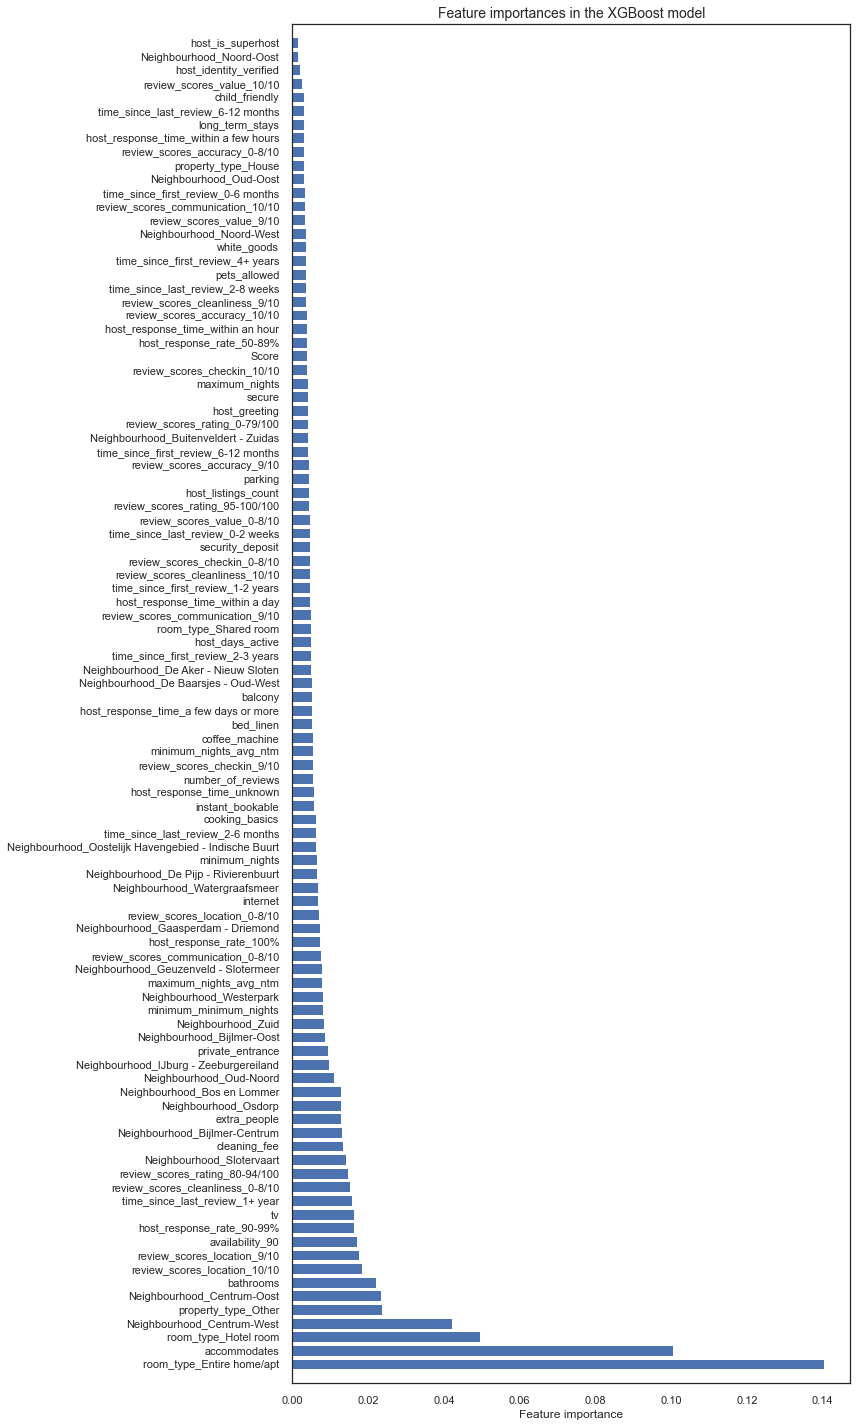

In [205]:
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [209]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Flatten, SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation

In [213]:
ACCURACY_THRESHOLD = 0.80

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > ACCURACY_THRESHOLD:
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [214]:
class My_model(keras.Model):
    def __init__(self):
        super(My_model,self).__init__()
        self.dense1=layers.Dense(1028)
        self.dense2=layers.Dense(512)
        self.dense3=layers.Dense(1028)
        self.dense4=layers.Dense(64)
        self.dense5=layers.Dense(1)
        self.bn= BatchNormalization()
        self.drop1= Dropout(0.05)
        self.drop2= Dropout(0.05)
    def call(self,input_tensor):
        x=tf.nn.relu(self.dense1(input_tensor))
        x=self.drop2(x)
        x=tf.nn.relu(self.dense2(x))
        x=self.drop2(x)
        x=tf.nn.relu(self.dense3(x))
        x=self.drop2(x)
        x=tf.nn.relu(self.dense4(x))
        x=self.drop2(x)
        return tf.nn.relu(self.dense5(x))

In [215]:
model=My_model()
def R_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, residual/total)
    return r2    

In [216]:
model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.mean_squared_error,metrics=[R_squared]) 

In [218]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150, batch_size=128,callbacks=[callbacks])

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1944/1944 [==============================] - 62s 32ms/step - loss: 0.2351 - R_squared: 0.0799 - val_loss: 0.1535 - val_R_squared: 0.3918
Epoch 2/150
1944/1944 [==============================] - 62s 32ms/step - loss: 0.1307 - R_squared: 0.4847 - val_loss: 0.0709 - val_R_squared: 0.7198
Epoch 3/150
1944/1944 [==============================] - 63s 32ms/step - loss: 0.0994 - R_squared: 0.6082 - val_loss: 0.0757 - val_R_squared: 0.6999
Epoch 4/150
1944/1944 [==============================] - 63s 

1944/1944 [==============================] - 61s 31ms/step - loss: 0.0040 - R_squared: 0.9843 - val_loss: 0.0021 - val_R_squared: 0.9917
Epoch 104/150
1944/1944 [==============================] - 61s 31ms/step - loss: 0.0042 - R_squared: 0.9835 - val_loss: 0.0021 - val_R_squared: 0.9920
Epoch 105/150
1944/1944 [==============================] - 60s 31ms/step - loss: 0.0042 - R_squared: 0.9838 - val_loss: 0.0016 - val_R_squared: 0.9937
Epoch 106/150
1944/1944 [==============================] - 73s 37ms/step - loss: 0.0039 - R_squared: 0.9848 - val_loss: 0.0019 - val_R_squared: 0.9926
Epoch 107/150
1944/1944 [==============================] - 74s 38ms/step - loss: 0.0040 - R_squared: 0.9845 - val_loss: 0.0012 - val_R_squared: 0.9953
Epoch 108/150
1944/1944 [==============================] - 76s 39ms/step - loss: 0.0040 - R_squared: 0.9844 - val_loss: 0.0017 - val_R_squared: 0.9932
Epoch 109/150
1944/1944 [==============================] - 76s 39ms/step - loss: 0.0041 - R_squared: 0.9839 

In [220]:
model.save_weights("model_weights.h5")

In [ ]:
training_preds=model.predict(X_train)
val_preds = model.predict(X_test)

In [ ]:
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds,4)))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds,4)))

In [222]:
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.tree import *

In [ ]:
xgb_reg_start = time.time()

s=SVR()
s.fit(X_train, y_train)
training_preds_s= s.predict(X_train)
val_preds_s = s.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_s),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_s,4)))
print("\nTraining r2:", round(r2_score(y_train, training_preds_s),4))
print("Validation r2:", round(r2_score(y_test, val_preds_s,4)))